In [1]:
import math
# import random

import gym
import numpy

import jax
import time
# from numpy import random

from jax import grad, value_and_grad
import jax.numpy as np
from jax import random, jit, jacfwd
from jax.ops import index, index_add, index_update

from collections import namedtuple


In [2]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [3]:
ParamTuple = namedtuple('Params', [
    "g",
    "m",
    "l",
    "dt",
    "max_torque",
    "max_speed"
])

params = ParamTuple(10, 1, 1, 0.05, 2, 8)

T = 200

In [4]:
@jit
def angle_normalize(x):
    return ((x+np.pi) % (2*np.pi)) - np.pi

@jit
def controlledPendulumStep_scan(state_and_params, u):
    th, thdot, params = state_and_params

    u = np.clip(u, -params.max_torque, params.max_torque)
    
    thdot = np.clip(
        thdot + (-3.0 * params.g / (2 * params.l) * np.sin(th + np.pi) + 3.0 / (params.m * params.l ** 2) * u) * params.dt,
        -params.max_speed,
        params.max_speed
    )
    th = th + thdot * params.dt

    cost = angle_normalize(th) ** 2 + .1 * thdot ** 2 + .001 * (u ** 2)
    # newthdot = newthdot, -max_speed, max_speed)

    return (th, thdot, params), np.array((th, thdot, cost))

@jit
def pendulumTraj_scan(th0, thdot0, uVect, params):
    state = (th0, thdot0, params)
    _, traj = jax.lax.scan(controlledPendulumStep_scan, state, uVect)
    return traj

@jit
def costOfTrajectory(traj):
    return np.sum(traj[:,2])

@jit
def pendulumTrajCost_scan(th0, thdot0, uVect, params):
    traj = pendulumTraj_scan(th0, thdot0, uVect, params)   
    return costOfTrajectory(traj)


trajectoryGrad_scan = jax.jit(grad(pendulumTrajCost_scan, argnums=2))
trajectoryValAndGrad_scan = jax.jit(value_and_grad(pendulumTrajCost_scan, argnums=2))



In [5]:
@jit
def controlledPendulumStep_derivs(th, thdot, params):
    d_thdot = (-3 * params.g / (2 * params.l) * np.sin(th + np.pi) + 3. / (params.m * params.l ** 2) * 0) * params.dt
    newthdot = thdot + d_thdot
    d_th = newthdot * params.dt

    return np.array((d_th, d_thdot))


In [6]:
traj = pendulumTraj_scan(np.pi/2, -3.0, np.zeros(200), params)


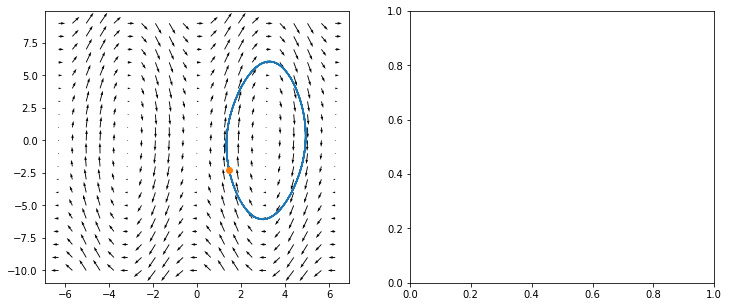

In [7]:

def plotTrajInPhaseSpace(traj, params, uVect=None):
    X = np.linspace(-2*np.pi, 2*np.pi, 21)
    Y = np.arange(-params.max_speed-2, params.max_speed+2, 1)

    U, V = np.meshgrid(X, Y)
    gridshape = U.shape

    THDOT, THDOTDOT = controlledPendulumStep_derivs(
        U.ravel(),
        V.ravel(),
        params
    )

    THDOT = THDOT.reshape(gridshape)
    THDOTDOT = THDOTDOT.reshape(gridshape)

    fig, (axPhase, axU) = plt.subplots(1,2,figsize=(12,5))
    q = axPhase.quiver(X, Y, THDOT, THDOTDOT)
    axPhase.plot(traj[:,0], traj[:,1])
    axPhase.plot(traj[0,0], traj[0,1], "o")

    if uVect is not None:
        axU.plot(uVect)

    plt.show()

plotTrajInPhaseSpace(traj, params)



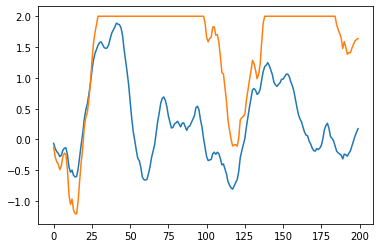

In [8]:
@jit
def dampedSpringNoiseStep(state, __ARG_NOT_USED = None):
    x, v, sigma, theta, phi, key = state
    key, subkey = random.split(key)
    v += -theta*x - phi*v + sigma*random.normal(subkey)
    x += v
    return (x, v, sigma, theta, phi, key), x

def dampedSpringNoiseScan(T, sigma=0.5, theta=0.05, phi=0.01, key=random.PRNGKey(0)):
    state = (0.0, 0.0, sigma, theta, phi, key)
    _, noise = jax.lax.scan(dampedSpringNoiseStep, state, None, length=T)
    return noise

dampedSpringNoiseJit = jit(dampedSpringNoiseScan, static_argnums=(0,))

# plt.plot(dampedSpringNoiseJit(200, sigma=.2, theta=.01,phi=.1))
plt.plot(dampedSpringNoiseJit(200, sigma=.05, theta=.02,phi=.1))
# plt.plot(dampedSpringNoiseJit(200, sigma=.2, theta=.01,phi=.01))
# plt.plot(dampedSpringNoiseJit(200, sigma=.2, theta=.1,phi=.01))
plt.plot(np.clip(
    dampedSpringNoiseJit(200, sigma=.1, theta=.005,phi=.2),
    -params.max_torque,
    params.max_torque)
)

In [9]:
def get_best_random_control(best_so_far, th, thdot, params, random_starts, horizon): 
    best_traj_cost, best_traj, best_u = best_so_far
    for j in range(random_starts):
        # uVect = 2*numpy.random.randn(T-t)
        key = random.PRNGKey(int(numpy.random.rand(1)*1000000))
        uVect = np.clip(
            dampedSpringNoiseJit(horizon, sigma=.2, theta=.005, phi=.2, key=key),
            -params.max_torque,
            params.max_torque
        )
        traj = pendulumTraj_scan(th, thdot, uVect, params)
        traj_cost = costOfTrajectory(traj)
        if traj_cost < best_traj_cost:
            best_traj_cost = traj_cost
            best_traj = traj
            best_u = uVect
    return best_traj_cost, best_traj, best_u

def optimize_control(best_so_far, th, thdot, params, opt_iters, LR):
    best_traj_cost, best_traj, best_u = best_so_far
    uVect = best_u
    for i in range(opt_iters):
        dgdu = trajectoryGrad_scan(th, thdot, uVect, params)
        uVect = uVect - LR*(0.99**i) * dgdu/np.linalg.norm(dgdu)
        traj = pendulumTraj_scan(th, thdot, uVect, params)
        traj_cost = costOfTrajectory(traj)
        if traj_cost < best_traj_cost:
            best_traj_cost = traj_cost
            best_traj = traj
            best_u = uVect
    return best_traj_cost, best_traj, best_u

In [20]:
import tree_dynamics_agent as tda
from importlib import reload
reload(tda)

<module 'tree_dynamics_agent' from '/home/bc/projects/deep_rl/jax/tree_dynamics_agent.py'>

In [21]:
tda.Agent(
    state=np.array([[1],[2]]),
    dynamics_layer_sizes=[3,10,2],
    reward_layer_sizes=[3,5,5,1],
    value_layer_sizes=[2,5,1],
    obs_dim=2,
    act_dim=1,
    memory_size=100000,
    batch_size=64,
    target_num_leaves=20
    )

In [ ]:
delta_S

rand_state_0 = (0.0, 0.0, sigma, theta, phi, key)

for i in range(num_episodes):
    state = env.reset()

    value_est = Value(state)

    new_state_node = Node(
        action=None,
        state=state,
        noise_state=rand_state_0,
        value_est=value_est
    )
    T = tree(init_root=new_state_node)

    for t in range(max_timesteps):
        while T.num_leaves() < target_num_leaves:
            state_node = T.softmax_sample_leaf_states()
            state = state_node.state
            noise_state = state_node.noise_state
            noise_state, action = dampedSpringNoiseStep(state.noise_state)
            state_est = state + DynamicsFn.est(state, action)
            reward_est = RewardFn.est(state_est, action)
            value_est = ValueFn.est(state_est)

            new_state_node = Node(
                action=action,
                state=state_est,
                noise_state=noise_state,
                value_est=value_est
            )

            T.add_state(
                parent=state_node,
                child=new_state_node,
                edge_reward=reward_est
            )
        
        target_node = T.softmax_sample_leaf_states()
        next_node = T.step_toward_and_reroot(target_node)
        action = next_node.action
        # NOTE does there need to be a "done" estimator
        last_state = state
        state, reward, done, _ = env.step(action)
        
        agent.update(last_state, action, reward, state)
        agent.learn()
        DynamicsFn.update(state, last_state, action)
        RewardFn.update(reward, state, action)
        ValueFn.update(reward, state) # ?



